<a href="https://colab.research.google.com/github/Ruchika-11/EVA-7/blob/main/Assignment_5/Session5colab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## **Addidng Data Augmentation(Rotation) and LR Scheduler** 

### ***Target:*** 
We'll add one of the Data Augmentation techniques like rotation to stabilize the accuracy. We'll also play around with the learning rates to see what difference it creates.  
### ***Results:*** 
Parameters: 8,790      
Best Train Accuracy: 99.26%          
Best Test Accuracy: 99.34%              
### ***Analysis:*** 
No overfitting is seen. In Fact, the model is underfitting now.    
Removed dropout since it was not able to help the model with stability.            
Adding "rotation" and "reducing the learning rate after 6th epoch" has helped in increasing the model's accuracy as well as has made it stable. The model has almost reached the desired level of accuracy. 


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Using Sequential to create a small model. When `self.convblock1` is run,
        # input will first be passed to `Conv2d(1,16,3)`. The output of
        # `Conv2d(1,16,3)` will be used as the input to the `ReLU`;

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.Dropout(0.1)
        ) # output_size = 26
        
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), stride=1, padding=0, bias=False),
            nn.ReLU(), 
            nn.BatchNorm2d(20),
            #nn.Dropout(0.1)
        ) # output_size = 24

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.Dropout(0.1)
        ) # output_size = 24

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            #nn.Dropout(0.1)  
        ) # output_size = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=20, kernel_size=(3, 3), stride=1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            #nn.Dropout(0.1)
        ) # output_size = 8

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10), 
            #nn.Dropout(0.1)
        ) # output_size = 8

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.Dropout(0.1)
        ) # output_size = 6

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
            Conv2d-4           [-1, 20, 24, 24]           1,800
              ReLU-5           [-1, 20, 24, 24]               0
       BatchNorm2d-6           [-1, 20, 24, 24]              40
            Conv2d-7           [-1, 10, 24, 24]             200
              ReLU-8           [-1, 10, 24, 24]               0
       BatchNorm2d-9           [-1, 10, 24, 24]              20
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 20, 10, 10]           1,800
             ReLU-12           [-1, 20, 10, 10]               0
      BatchNorm2d-13           [-1, 20, 10, 10]              40
           Conv2d-14             [-1, 2

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        
        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
scheduler = StepLR(optimizer, step_size = 6, gamma = 0.1)

for epoch in range(1, 16):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:75: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.14945577085018158 Batch_id=468 Accuracy=93.12: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s]



Test set: Average loss: 0.1106, Accuracy: 9799/10000 (97.99%)

EPOCH: 2


Loss=0.059375036507844925 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:26<00:00, 17.71it/s]



Test set: Average loss: 0.0625, Accuracy: 9868/10000 (98.68%)

EPOCH: 3


Loss=0.08279135078191757 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:26<00:00, 17.54it/s]



Test set: Average loss: 0.0560, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.059604525566101074 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]



Test set: Average loss: 0.0439, Accuracy: 9898/10000 (98.98%)

EPOCH: 5


Loss=0.04449733719229698 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:26<00:00, 17.88it/s]



Test set: Average loss: 0.0457, Accuracy: 9882/10000 (98.82%)

EPOCH: 6


Loss=0.06299451738595963 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:26<00:00, 17.80it/s]



Test set: Average loss: 0.0427, Accuracy: 9886/10000 (98.86%)

EPOCH: 7


Loss=0.085678331553936 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:26<00:00, 17.75it/s]



Test set: Average loss: 0.0346, Accuracy: 9913/10000 (99.13%)

EPOCH: 8


Loss=0.032048024237155914 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:26<00:00, 17.66it/s]



Test set: Average loss: 0.0328, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


Loss=0.06353000551462173 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:26<00:00, 17.77it/s]



Test set: Average loss: 0.0354, Accuracy: 9907/10000 (99.07%)

EPOCH: 10


Loss=0.039456941187381744 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:26<00:00, 17.93it/s]



Test set: Average loss: 0.0295, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.045781150460243225 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]



Test set: Average loss: 0.0305, Accuracy: 9909/10000 (99.09%)

EPOCH: 12


Loss=0.01102121826261282 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:25<00:00, 18.19it/s]



Test set: Average loss: 0.0284, Accuracy: 9925/10000 (99.25%)

EPOCH: 13


Loss=0.08179685473442078 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:25<00:00, 18.38it/s]



Test set: Average loss: 0.0293, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


Loss=0.03129316493868828 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]



Test set: Average loss: 0.0274, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.04773068055510521 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]



Test set: Average loss: 0.0238, Accuracy: 9934/10000 (99.34%)



Text(0.5, 1.0, 'Test Accuracy')

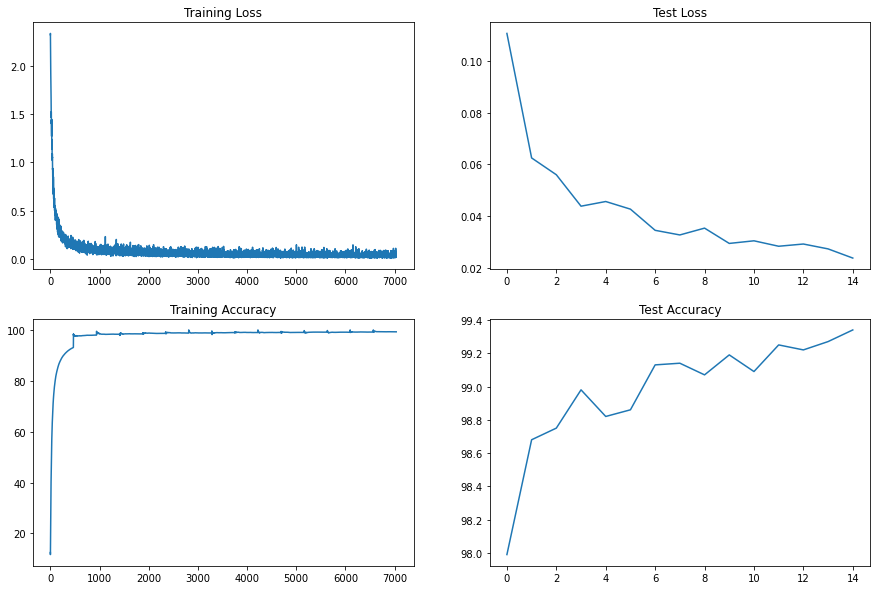

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")